In [1]:
# location of the data set. Name files with year
fileLocation = '/Code/spark/LAB4/data/200*.csv'

# number of trees in forest
nbrOfTreesInForest = [4, 8, 16]

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
# Create spark session
spark = SparkSession.builder.appName("theappname").getOrCreate()
# Load data from files
df = spark.read.csv(fileLocation, mode="DROPMALFORMED", inferSchema=True, header = True)

# During debug just load a fraction of the sample dataset to reduce computing time
#df = df.sample(fraction=0.1)

from pyspark.sql.functions import  length, lpad
from pyspark.sql.types import IntegerType
# Do first filtering 
selection = df\
    .where((df.Diverted == 0) & (df.CancellationCode.isNull()) & (df.TailNum.rlike("^([A-Z]|[a-z]|[0-9])"
                                                                                                                  "+$")) & ((length(df.DepTime) == 4) | (length(df.DepTime) == 3)) & (length(df.ArrTime) == 4) | (length(df.ArrTime) == 3))\
    .where(df['TailNum'].isNotNull())\
    .withColumn("DepTime", when(length(df.DepTime) == 3, lpad(df['DepTime'], 4,'0')).otherwise(df['DepTime']))\
    .withColumn("ArrTime", when(length(df.ArrTime) == 3, lpad(df['ArrTime'], 4,'0')).otherwise(df['ArrTime']))\
    .sort(asc('Year'), 'Month', 'DayofMonth', 'ArrTime')\
    .withColumn("ArrDelay", df.ArrDelay.cast(IntegerType()))\
    .withColumn("DepDelay", df["DepDelay"].cast(IntegerType()))\
    .withColumn("CarrierDelay", df["CarrierDelay"].cast(IntegerType()))\
    .withColumn("WeatherDelay", df["WeatherDelay"].cast(IntegerType()))\
    .withColumn("NASDelay", df["NASDelay"].cast(IntegerType()))\
    .withColumn("SecurityDelay", df["SecurityDelay"].cast(IntegerType()))\
    .withColumn("LateAircraftDelay", df["LateAircraftDelay"].cast(IntegerType()))\
    .fillna(0, subset=['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay' ])


#from pyspark.sql.functions import lag
from pyspark.sql.types import BinaryType
#from pyspark.sql import Window
#w = Window.orderBy("Year", "Month", "DayofMonth", "ArrTime")
#w = Window.partitionBy ("Year", "Month", "DayofMonth", "ArrTime").orderBy("Year", "Month", "DayofMonth", "ArrTime")

# Define the FFA (Federal Aviation Administration) function
udf(returnType=BinaryType())
IsLate  = lambda x : x["ArrDelay"] > 15

# Create a new column 'IsLate' stating that the flight was considered delay or not
selection = selection\
    .withColumn("IsLate", (IsLate(selection)))
#    .withColumn("NbrOfPreviousLateFlights",(lag(selection['ArrDelay'], 1,0).over(w)  > 15 if 1 else 0).cast(IntegerType()) + (lag(selection['ArrDelay'], 2,0).over(w)  > 15 if 1 else 0).cast(IntegerType()) + (lag(selection['ArrDelay'], 3,0).over(w)  > 15 if 1 else 0).cast(IntegerType()))\


In [3]:
# convert to pandas since we a running on a single node and the fact that I wanted to learn about pandas
basePanda = selection.toPandas()

# remove the dataframe from memory
selection.unpersist()


DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: string, AirTime: string, ArrDelay: int, DepDelay: int, Origin: string, Dest: string, Distance: int, TaxiIn: string, TaxiOut: string, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: int, WeatherDelay: int, NASDelay: int, SecurityDelay: int, LateAircraftDelay: int, IsLate: boolean]

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split the data into training and testing sets
lb_make = LabelEncoder()
#basePanda = superBasePanda[['Year', 'Month', 'DayofMonth', 'DepTime', 'Origin', 'Dest', 'TailNum','UniqueCarrier','TaxiOut', 'DepDelay','Distance', 'LateAircraftDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'IsLate']]
#basePanda = basePanda.dropna()
basePanda['Origin_code'] = lb_make.fit_transform (basePanda['Origin'])
basePanda['Dest_code'] = lb_make.fit_transform (basePanda['Dest'])
basePanda['UniqueCarrier_code'] = lb_make.fit_transform (basePanda['UniqueCarrier'])
basePanda['TailNum_code'] = lb_make.fit_transform (basePanda['TailNum'])
basePanda['DepTime_code'] = lb_make.fit_transform (basePanda['DepTime'])
basePanda['TaxiOut_code'] = lb_make.fit_transform (basePanda['TaxiOut'])
basePanda['DepTimeHour'] = lb_make.fit_transform (basePanda['DepTime'].str[0:2])    
basePanda = basePanda.drop('Origin', axis = 1) 
basePanda = basePanda.drop('Dest', axis = 1)
basePanda = basePanda.drop('UniqueCarrier', axis = 1) 
basePanda = basePanda.drop('TailNum', axis = 1) 
basePanda = basePanda.drop('CancellationCode', axis = 1)
basePanda = basePanda.drop('Cancelled', axis = 1)
basePanda = basePanda.drop('ArrTime', axis = 1)
basePanda = basePanda.drop('DepTime', axis = 1)
basePanda = basePanda.drop('TaxiOut', axis = 1)
basePanda = basePanda.drop('ActualElapsedTime', axis = 1)
basePanda = basePanda.drop('CRSElapsedTime', axis = 1)
basePanda = basePanda.drop('AirTime', axis = 1)
basePanda = basePanda.drop('TaxiIn', axis = 1)
labelsPanda  = basePanda['IsLate']
labels = np.array(labelsPanda)
features = basePanda.drop('IsLate', axis = 1) 

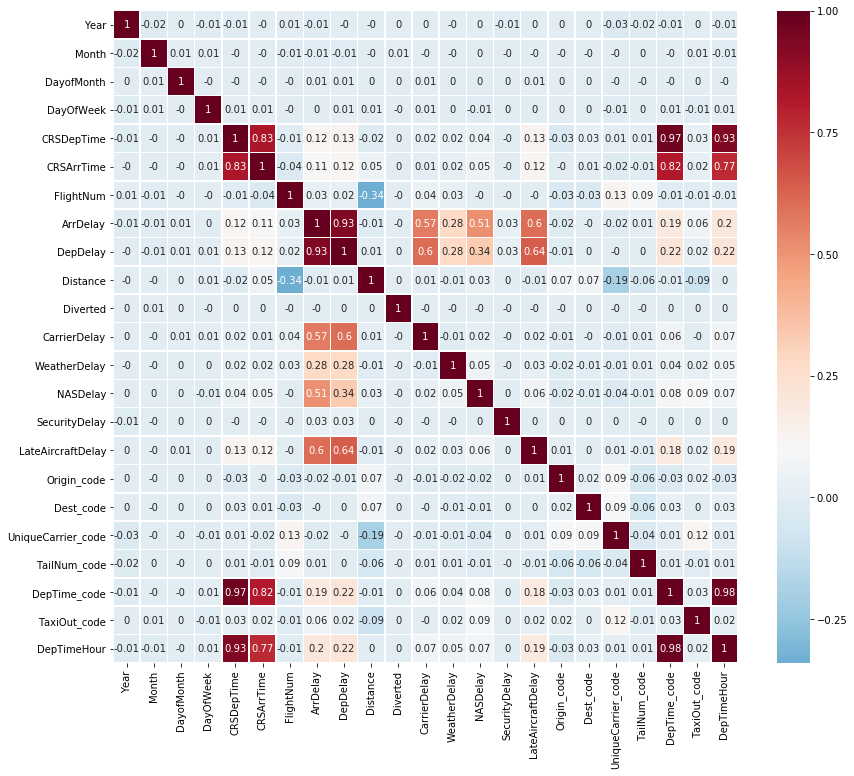

CRSDepTime           0.12
CRSArrTime           0.11
ArrDelay             1.00
DepDelay             0.93
CarrierDelay         0.57
WeatherDelay         0.28
NASDelay             0.51
LateAircraftDelay    0.60
DepTime_code         0.19
DepTimeHour          0.20
Name: ArrDelay, dtype: float64


In [4]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
features = features.round(2)
corr = features.corr()
corr = corr.round(2)
plt.figure(figsize=(14,12))
sb.heatmap(corr, annot=True, cmap='RdBu_r', linewidth=0.5, center=0.1)
plt.savefig('heatmap.png',  dpi=100)
plt.show()

corr_target= np.abs(corr["ArrDelay"])
# Select the features with a correlation_target larger than 0.1
# The 0.1 might be a bit low but as the number of features is low 
# We can be a bit greedy and select a low limit (many features)
selected_features_filter_method= corr_target[corr_target>0.1]

print(selected_features_filter_method)

# select the features columns from the dataset. I.E the actual data
# features = basePanda[selected_features_filter_method.axes[0].tolist()]

In [5]:
# Drop the ArrDelay as we do not need anymore
features = features.drop('ArrDelay', axis = 1)


# Start the forward selection from 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

sfs = SFS(LinearRegression(),
           k_features=6,
           forward=True)

sfs.fit(features, labels)
sfs.k_feature_names_ 


('DepDelay',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'LateAircraftDelay',
 'DepTime_code')

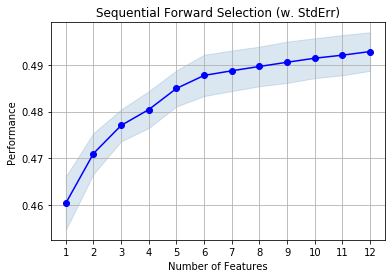

In [6]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.savefig('sfs.png')
plt.show()


In [20]:
from sklearn.decomposition import PCA

allFeatures = list(sfs.k_feature_names_)
#allFeatures.append('IsLate')
pcadf = basePanda[allFeatures]

pca_samples = pcadf.sample(100)

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(pca_samples)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PCA0', 'PCA1', 'PCA2'])

result = pd.concat([principalDf, labelsPanda], axis = 1)


ValueError: 'c' argument has 100 elements, which is not acceptable for use with 'x' with size 100, 'y' with size 100.

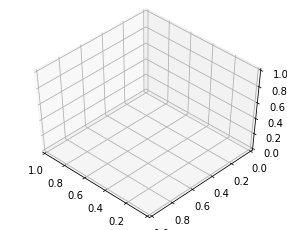

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

y = np.choose(result[['IsLate']], [0, 1]).astype(np.float)
#yt = y.transpose()
ax.scatter(result[['PCA0']], result[['PCA1']], result[['PCA2']]\
    , c=y, cmap=plt.cm.nipy_spectral,        edgecolor='k')

#ax.w_xaxis.set_ticklabels([])
#ax.w_yaxis.set_ticklabels([])
#ax.w_zaxis.set_ticklabels([])

plt.show()


In [6]:
# Convert from pandas to array to match the 'train_test_split' method
features = np.array(features)
# split the features/labels into train and test sets 
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [9]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

def run_random_forest(tree_size):
    print('Fitting random forest model with {} trees'.format(tree_size))
    # Instantiate model with 4 decision trees
    rf = RandomForestClassifier(n_estimators = tree_size)
    # Train the model on training data
    rf.fit(train_features, train_labels);
    print("Random forest score: {:.4f} ".format(rf.score(test_features, test_labels)))
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    
    print(classification_report(test_labels, predictions, target_names=['Not late','Late'], digits=4))
    
    # calculate the probalistics
    rf_probs = rf.predict_proba(test_features)[:, 1]
    # calculate the roc auc score to se the performance of the DR
    roc_value = roc_auc_score(test_labels, rf_probs)
    
    print("AUC ROC score: {:.4f} ".format(roc_value))
    print("-----------------------------------------------------")

for tree_size in nbrOfTreesInForest:
    run_random_forest(tree_size)

Fitting random forest model with 4 trees
Random forest score: 0.9984 
              precision    recall  f1-score   support

    Not late     0.9988    0.9992    0.9990   4071891
        Late     0.9971    0.9956    0.9964   1143510

    accuracy                         0.9984   5215401
   macro avg     0.9979    0.9974    0.9977   5215401
weighted avg     0.9984    0.9984    0.9984   5215401

AUC ROC score: 0.9999 
-----------------------------------------------------
Fitting random forest model with 8 trees
Random forest score: 0.9990 
              precision    recall  f1-score   support

    Not late     0.9997    0.9991    0.9994   4071891
        Late     0.9967    0.9988    0.9977   1143510

    accuracy                         0.9990   5215401
   macro avg     0.9982    0.9989    0.9985   5215401
weighted avg     0.9990    0.9990    0.9990   5215401

AUC ROC score: 1.0000 
-----------------------------------------------------
Fitting random forest model with 16 trees
Random for